# COSE461 Assignment 1: Word Vectors
### **Due 9:00 AM, Tue Mar 21**

Welcome to COSE461. 

## About using Colab
Our assignment will be in the form of Jupyter notebooks to be able to be run in Google Colab. Colab is an online editor that provides free access to a GPU, so you don't have to worry about the computing resources when doing the assignements. GPU can be accessed by `Edit->Notebook settings` or `수정->노트 설정` and choosing GPU in the Hardware accelerator dropdown (We will not be using a GPU in the current assignment, though). To get started, make a copy of the assignment by clicking `File->Save a copy in drive...` or `파일->드라이브에 사본 저장`.  You will need to be logged into a Google account, such as your @korea.ac.kr mail account.
 
 The code cells in Colab are executed on a `preemtible` VM instance. This means:
 - Every time you open the notebook, you will be assigned a different machine; run cells and files will be lost.
 - Even if you keep using a machine attached to notebook, it can be lost and altered with other machine after 24 hours.

Therefore, if you have some output that you don't want to lose, you should download them to your local machine or save them to your Google drive by mounting it to the VM instance. The former can be done by `File->Download` or `파일->다운로드`, where the latter can be done by using something similar to the following code snippet:



```
from google.colab import drive

# mount Google drive
drive.mount('/mnt/')

# You can run a linux command by putting ! at the start
# The following commands shows the number of files in your drive
!echo -e "\n# of files in /mnt/My Drive/:"
!ls -l "/mnt/My Drive/" | wc -l

```

One important limitation to Colab is that it disconnects from VM when is inactive for a few tens of minutes. So you should either check Colab periodically, or use something like [this](https://stackoverflow.com/questions/54057011/google-colab-session-timeout). If you have available computing resources and if you do not want to go through such inconvenience, feel free to use yours by recreating a similar environment to Colab.

---



# Word vectors
This assignment is based on the Stanford CS224n lecture by Christopher Manning. The followings are the import, data downloading, and unzipping statements. Do not modify, and simply run it once before going down.

In [1]:
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

np.random.seed(0)
random.seed(0)
!unzip -nq /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from co-occurrence matrices, and those derived via GloVe.

**Note on Terminology**: The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As Wikipedia states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

# Part 1: Count-based word vectors
#### You Shall know a word by the company it keeps (Firth, J. R. 1957:11)
Many word vector implementations are driven by the idea that **similar words**, i.e., (near) synonyms, **will be used in similar contexts**. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

## Co-occurence
A co-occurrence matrix counts how often things co-occur in some environment. Given some word  $w_i$  occurring in the document, we consider the context window surrounding  $w_i$ . Supposing our fixed window size is  $n$ , then this is the  $n$  preceding and  $n$  subsequent words in that document, i.e. words  $w_{i−n}…w_{i−1}$  and  $w_{i+1}…w_{i+n}$ . We build a co-occurrence matrix  $M$ , which is a symmetric word-by-word matrix in which  $M_{ij}$  is the number of times  $w_j$  appears inside  $w_i$ 's window among all documents.

**Example: Co-occurence with fixed window of $n=1$**

Document 1: *all that glitters is not gold*

Document 2: *all is well that ends well*


| *   |	`<START>`	| all	| that | glitters	| is	| not	| gold	| well	| ends	|`<END>`|
| --- | ---     | --- | ---  | ---      | --- | --- | ---   | ---   | ---   | --- |
|`<START>`	|0|	2|	0|	0|	0|	0|	0|	0|	0|	0| |
|all	|2	|0	|1	|0	|1	|0	|0	|0	|0	|0 |
|that	|0	|1	|0	|1	|0	|0	|0	|1	|1	|0 |
|glitters	|0	|0	|1	|0	|1	|0	|0	|0	|0	|0|
|is	|0	|1	|0	|1	|0	|1	|0	|1	|0	|0|
|not|	0|	0|	0|	0|	1|	0|	1|	0|	0|	0|
|gold|	0|	0|	0|	0|	0|	1|	0|	0|	0|	1|
|well|	0|	0|	1|	0|	1|	0|	0|	0|	1|	1|
|ends	|0	|0	|1	|0	|0	|0	|0	|1	|0	|0|
|`<END>`	|0	|0	|0	|0	|0	|0	|1	|1	|0	|0|

**Note:** In NLP, we often add `<START>` and `<END>` tokens to represent the beginning and end of sentences, paragraphs or documents. In thise case we imagine `<START>` and `<END>` tokens encapsulating each document, e.g., "`<START>` All that glitters is not gold `<END>`", and include these tokens in our co-occurrence counts.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run dimensionality reduction. In particular, we will run SVD (Singular Value Decomposition), which is a kind of generalized PCA (Principal Components Analysis) to select the top  $k$  principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is  $A$  with  $n$  rows corresponding to  $n$  words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal  $S$  matrix, and our new, shorter length- $k$  word vectors in  $U_k$.

<div align="center">

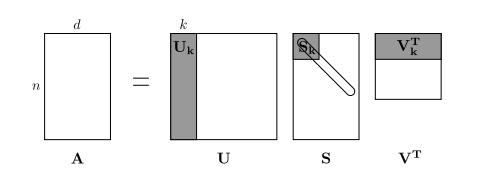

</div>


This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*.

**If you are not friendly to SVD:** you can refer to [this comprehensive tutorial](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf) or these lecture notes ([1](https://web.stanford.edu/class/cs168/l/l7.pdf), [2](http://theory.stanford.edu/~tim/s15/l/l8.pdf), [3](https://web.stanford.edu/class/cs168/l/l9.pdf) ) of Stanford CS168. While these materials give a great introduction to PCA/SVD, you do not have to understand all of these materials for this assignment or this class.

##Plotting Co-Occurrence Word Embeddings
Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell above, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see [this](https://www.nltk.org/book/ch02.html). We provide a `read_corpus` function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words. You do not have to perform any other kind of pre-processing.

In [2]:
START_TOKEN = '<START>'
END_TOKEN = '<END>'

def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

Let's have a look what these documents are like....

In [3]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

## Question 1.1: Implement `distinct_words` [code] (2 points)


Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with for loops, but it's more efficient to do it with Python list comprehensions. In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

Your returned corpus_words should be sorted. You can use python's sorted function for this.

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [4]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------
    # Write your implementation here.

    corpus_words = sorted(list(set([word for row in corpus for word in row])))
    num_corpus_words = len(corpus_words)

    # ------------------

    return corpus_words, num_corpus_words

Run below for sanity check - note that this is not an exhaustive check for correctness.

In [5]:
# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


## Question 1.2: Implement `compute_co_occurrence_matrix` [code] (3 points)
Write a method that constructs a co-occurrence matrix for a certain window-size  $n$  (with a default of 4), considering words  $n$  before and  $n$  after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this [Stanford cs231n Python NumPy tutorial](https://cs231n.github.io/python-numpy-tutorial/).

In [6]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2ind = {}
    
    # ------------------
    # Write your implementation here.

    i=0
    for word in words:
        word2ind.update({word : i})
        i=i+1

    M = np.zeros((num_words, num_words))
    
    for str in corpus:
        for strC in range(len(str)):
            for cnt in range(window_size):
                if (strC - cnt >= 1):
                    M[word2ind[str[strC]]][word2ind[str[strC - cnt - 1]]] += 1
                if (strC + cnt < len(str) - 1):
                    M[word2ind[str[strC]]][word2ind[str[strC + cnt + 1]]] += 1

    # ------------------

    return M, word2ind

Run below for sanity check - note that this is not an exhaustive check for correctness.

In [7]:
# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


## Question 1.3: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings.

**Note:** Please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) for SVD. While there are numbers of implementation of SVD (e.g. numpy, scipy, ...), it is challenging to apply full SVD to large corpora due to its high asymptotic complexity. Here we only need top $k$ vector components for relative small $k$, which is the case called Truncated SVD, and some iterative algorithms for this scale reasonably. The above implementation by sklean is an efficient randomized algorithm for calculating large-scale Truncated SVD.

In [8]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    # Write your implementation here.
    
    svd = TruncatedSVD(n_components=k, n_iter=n_iters) 
    M_reduced = svd.fit_transform(M)
    
    # ------------------

    print("Done.")
    return M_reduced

Run below for sanity check - note that the code below only check shapes.

In [9]:
# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


## Question 1.4: Implement `plot_embeddings` [code] (1 point)
Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](http://web.archive.org/web/20190924160434/https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at the [Matplotlib gallery](https://matplotlib.org/stable/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [10]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.


    for word in words:
      plt.scatter(M_reduced[word2ind[word]][0], M_reduced[word2ind[word]][1], marker = 'x', color = 'red')
      plt.text(M_reduced[word2ind[word]][0], M_reduced[word2ind[word]][1], word, fontsize=9)

    plt.show()
    
    # ------------------

Run below for sanity check - the plot produced should look like the "test solution plot" depicted below.


--------------------------------------------------------------------------------
Outputted Plot:


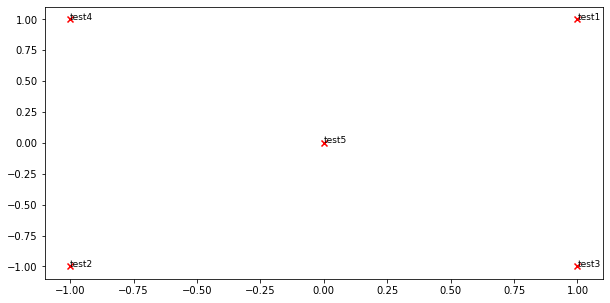

--------------------------------------------------------------------------------


In [11]:
print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

**Test Plot Solution**

<div align="center">

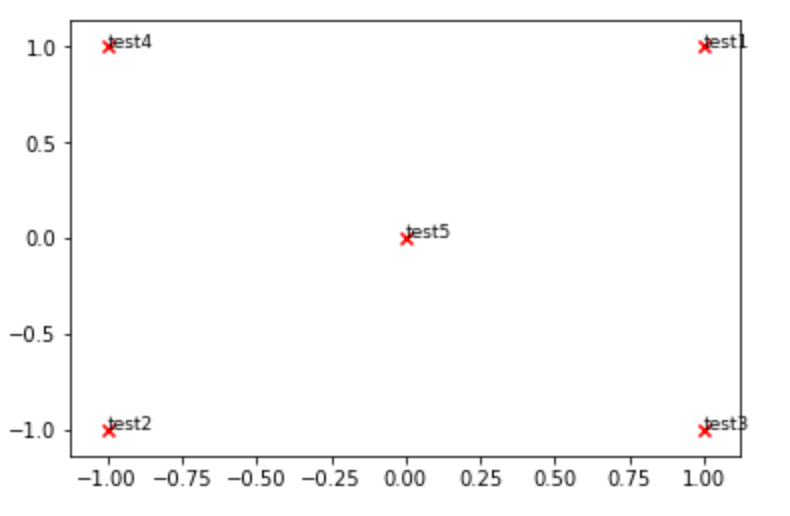
</div>

## Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "crude" (oil) corpus. Then we will use `TruncatedSVD` to compute 2-dimensional embeddings of each word. `TruncatedSVD` returns $US$, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness).

**Note:** The line of code below that does the normalizing uses the NumPy concept of broadcasting. If you don't know about broadcasting, check out [Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? **Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

Running Truncated SVD over 8185 words...
Done.


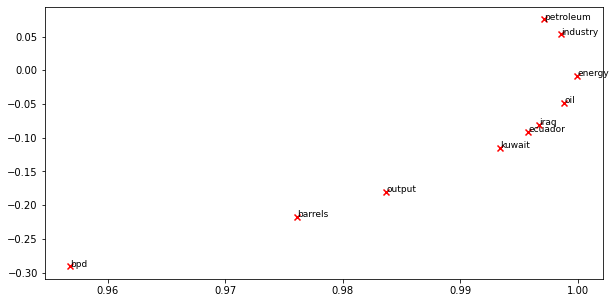

In [12]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)



---


**Write your answer here. You can write in either Korean or English.**

더 세분화하여 cluter를 볼 수도 있겠지만, 일단 크게 파악했을 때 kuwait, ecudor, irag, oil, energy, industry, petroleum 이 모여있다고 봤다.

barrels나 bpd 사이가 먼 것이 굉장히 의외였다. 
또, petroleum이 결국 oil 와 유사할텐데 oil - energy 관계보다 오히려 더 멀리 떨어져 있다는 점
barrels는 단위라는 점에서 석유가 있는 쪽에 더 뭉쳐있을 것이라고 생각했는데, 그렇지 않아 신기했다.



---



# Part 2: Prediction-Based Word Vectors (15 points)
As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

Then run the following cells to load the GloVe vectors into memory. **Note:** If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [13]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


**Note: If you are receiving a "reset by peer" error, rerun the cell to restart the download.**

## Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead. Run the following cells to:

1.   Put 10000 Glove vectors into a matrix $M$
2.   Run `reduce_to_k_dim` (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [14]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

Run the cell below to reduce 200-dimensional word embeddings to $k$ dimensions. This should be quick to run.

In [15]:
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


## Question 2.1: GloVe Plot Analysis [written] (3 points)
Run the cell below to plot the 2D GloVe embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you think should have? How is the plot different from the one generated earlier from the co-occurrence matrix? What is a possible cause for the difference?

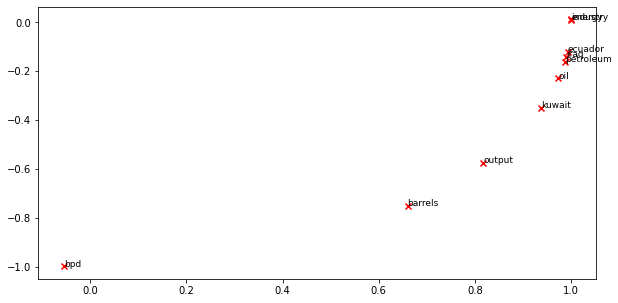

In [16]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']
plot_embeddings(M_reduced_normalized, word2ind, words)


---


**Write your answer here. You can write in either Korean or English.**

industry, energy, iraq, pcuador, petroleum, oil, kuwait 정도가 cluster를 이룬다고 할 수 있을 것 같다. 
조금 더 세분화해서 cluter를 구분하자면, pcuador, iraq, petroleum, oil / industry, energy로 cluter를 좁힐 수 있을 것 같다. 

이전과 다르게 나라 이름 끼리 모여있던 cluter 뭉치에 petroleum 및 oil이 더 가깝게 들어가 한 cluter로 보인다. 원유 생산국과 원유 및 기름의 관계를 좀 더 가중치 두듯 보아 cluter가 가까워지고, 그에 관련된 enegy, industry가 바로 주변에 위치해 차이를 불러 일으킨 것이 아닐까 단순히 생각해보았다.

bpd와 barrels는 여전히 상관관계가 없다는 양 먼 관계를 유지한다는 점이 신기하다. 

---



### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of $n$-dimensional vectors as points in $n$-dimensional space. If we take this perspective [$L^1$](https://mathworld.wolfram.com/L1-Norm.html) and [$L^2$](https://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:


<div align="center">

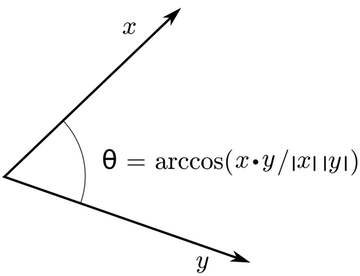

</div>

Instead of computing the actual angle, we can leave the similarity in terms of  similarity$=\cos(\theta)$. Formally, [the Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity)  $s$  between two vectors  $p$ and  $q$  is defined as:

$$s=\frac{p\cdot q}{\lVert p \rVert\lVert q \rVert},$$ where $s\in [-1, 1]$.

## Question 2.2: Words with Multiple Meanings [code + written] (1.5 points)
Polysemes and homonyms are words that have more than one meaning (see [this wiki](https://en.wikipedia.org/wiki/Polysemy) for details). Find a word with **at least two different meanings** such that the top-10 most similar words (according to cosine similarity) contain related words from **both** meanings. For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one.

Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain one of the meanings of the words)?

Note: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance, please check [the GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar).

In [17]:
print('10 Similar words to "leaves":', wv_from_bin.most_similar('leaves'))
# ------------------
# Write your implementation here.

print("[good working case]")
print('10 Similar words to "organ":', wv_from_bin.most_similar('organ'))
print('10 Similar words to "address":', wv_from_bin.most_similar('address'))
print('10 Similar words to "mouse":', wv_from_bin.most_similar('mouse'))
print("")
print("[bad working case]")
print('10 Similar words to "bill":', wv_from_bin.most_similar("bill"))
print('10 Similar words to "chip":', wv_from_bin.most_similar("chip"))
print('10 Similar words to "degree":', wv_from_bin.most_similar("degree"))
print('10 Similar words to "fine":', wv_from_bin.most_similar("fine"))

# ------------------

10 Similar words to "leaves": [('ends', 0.6128067970275879), ('leaf', 0.6027014851570129), ('stems', 0.5998532176017761), ('takes', 0.5902854800224304), ('leaving', 0.5761634111404419), ('grows', 0.5663397312164307), ('flowers', 0.5600922107696533), ('turns', 0.5536050796508789), ('leave', 0.5496848821640015), ('goes', 0.5434924960136414)]
[good working case]
10 Similar words to "organ": [('organs', 0.7207353711128235), ('transplants', 0.5738605856895447), ('transplantation', 0.5395218133926392), ('harpsichord', 0.5341777205467224), ('transplant', 0.5284041166305542), ('farfisa', 0.5190308094024658), ('piano', 0.5074425339698792), ('hammond', 0.5044703483581543), ('choir', 0.48512497544288635), ('donor', 0.48483818769454956)]
10 Similar words to "address": [('addresses', 0.7622557878494263), ('addressed', 0.7578191757202148), ('addressing', 0.7515827417373657), ('____________________________________________', 0.6677969098091125), ('speech', 0.6646221280097961), ('message', 0.6392382383



---


**Write your answer here. You can write in either Korean or English.**

잘 찾은 케이스와 못 찾은 케이스들을 여러 개 찾아보며, 잘 작동하지 않은 케이스들에 대한 이유를 생각해보았다.

[잘 찾은 케이스 1] organ : 1. (사람의) 장기[기관], 2. (파이프) 오르간
- 1번의 뜻으로 관련된 단어 : organs, transplants, transplantation, transplant, donor
- 2번의 뜻으로 관련된 단어 : harpsichord, farfisa, piano, hammond, choir

[잘 찾은 케이스 2] address : 1. 주소 (지번, 인터넷), (~주소로 우편물을) 보내다 2. 연설하다 
- 1번 뜻으로 관련된 단어 : addresses, ____________________________________________, 
- 2번 뜻으로 관련된 단어 : speech, questions, discuss, answer, call
- 다 사용될 수 있는 단어 : addressed, addressing, message

[잘 찾은 케이스 3] mouse : 1. 쥐 2. (컴퓨터) 마우스
- 1번 뜻으로 관련된 단어 : mice, rat, rabbit, cat, mickey
- 2번 뜻으로 관련된 단어 : keyboard, cursor, trackball, joystick, clicks

세 가지 케이스를 보면 단어의 뜻이 한 쪽으로 치우쳐져 쓰이지 않는 편에 속하고, 해당 단어의 여러 뜻을 말해보라고 했을 때 그 다의어, 동음이의어의 다양한 뜻을 이야기할 수 있는 단어들임을 알 수 있다.

여기서 재밌는 점은, address에서 ___는 아마 주소를 적는 칸을 뜻하는 것일텐데, 이것 또한 자주 사용되는 '뜻' 처럼 계산하여 산출해냈다는 점이다. 계산 방식에 따라 참 충실한 결과를 내었다는 증거이다.



[못 찾은 케이스 1] bill : 1. 고지서, 영수증, 계산서, 청구서 2. (국회에 제출된) 법안 3. 지폐
- 2번 뜻으로 관련된 단어 : legislation, passed, bills, senate, amendment, proposal, provision, enacted, amendments
- ? : bills, measure 

[못 찾은 케이스 2] chip : 1. 이가 빠진 흔적 2. 조각 3. (전자공학) 칩
- 3번 뜻으로 관련된 단어 : chips, intel, semiconductor, microchip, microprocessor, computer, dram, tech, amd
- ? : markers, chips

[못 찾은 케이스 3] degree : 1. 정도 2. 학위
- 2번 뜻으로 관련된 단어 : bachelor, doctorate, graduate, undergradage, graduated, phd, b.a., ph.d., graduating
- ? : degrees

[못 찾은 케이스 4] fine : 1. 좋은, 괜찮은 2. 벌금
- 1번 뜻으로 관련된 단어 : well, good, nice, done, quality
- 억지스럽지만 1번과 연상되는 단어 : art, making, make, just


못 찾았다고 판단한 케이스에는 여러가지가 있는데, 일단 한 쪽 의미에만 치중하여 찾은 케이스를 볼 수 있다. 두 단어가 인터넷 상에서 쓰일 때 한 쪽 의미로만 사용되는 경우가 잦아 그 유의어로 찾아내지 못한 것으로 보이나 다른 의미 또한 많이 쓰이는 단어이기에 다소 아쉬운 케이스라고 생각했다.

또, 아예 연관 단어를 제대로 찾아내지 못하고 함께 자주 쓰이는 명사들을 그냥 쭉 나열하는 것에 불과한 케이스도 볼 수 있다. 목표가 '관련 단어를 포함하도록' 이기에 넓은 관점에서 보면 해당 단어가 관련 의미와 자주 쓰이고 연상하는 정도가 높은 단어이기에 포함관계다! 라고 볼 수도 있겠지만, 조금 억지스러운 면이 많아 그 의미를 잘 찾지 못했다고 생각했다.


---



## Question 2.3: Synonyms & Antonyms [code + written] (2 points)

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply $1 - \text{Cosine Similarity}$.

Find three words  $(w_1,w_2,w_3)$  where  $w_1$  and  $w_2$  are synonyms and  $w_1$  and  $w_3$  are antonyms, but Cosine Distance  $(w_1,w_3)<  \text{Cosine Distance}  (w_1,w_2)$ .

As an example,  $w_1 =``\text{happy}"$ is closer to  $w_3 =``\text{sad}"$ than to  $w_2 =``\text{cheerful}"$. Please find a different example that satisfies the above. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see [the GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance) for further assistance.


In [18]:
print('Cosine distance between "happy" and "sad":', wv_from_bin.distance('happy', 'sad'))
print('Cosine distance between "happy" and "cheerful":', wv_from_bin.distance('happy', 'cheerful'))
# ------------------
# Write your implementation here.

print('Cosine distance between "many" and "much":', wv_from_bin.distance('many', 'much'))
print('Cosine distance between "many" and "few":', wv_from_bin.distance('many', 'few'))

print('Cosine distance between "good" and "bad":', wv_from_bin.distance('good', 'bad'))
print('Cosine distance between "good" and "awsome":', wv_from_bin.distance('good', 'awesome'))


# ------------------

Cosine distance between "happy" and "sad": 0.4040136933326721
Cosine distance between "happy" and "cheerful": 0.5172466933727264
Cosine distance between "many" and "much": 0.3375307321548462
Cosine distance between "many" and "few": 0.142886221408844
Cosine distance between "good" and "bad": 0.28903740644454956
Cosine distance between "good" and "awsome": 0.5967656075954437




---


**Write your answer here. You can write in either Korean or English.**

유의어 간의 사용 빈도가 적고, 유사한 의미지만 사용되는 상황 등에서 약간의 차이가 있어 반의어보다 연관성이 더 낮은 것처럼 계산되었기 때문이라고 생각한다.

---



## Question 2.4: Analogies with Word Vectors [written] (1.5 points)
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies.

As an example, for the analogy "man : king :: woman : $x$" (read: man is to king as woman is to $x$), what is $x$?

In the cell below, we show you how to use word vectors to find $x$ using the `most_similar` function from the [GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar). The function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list (while omitting the input words, which are often the most similar; see [this paper](https://aclanthology.org/N18-2039.pdf) for more details). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [19]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.6978678703308105),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998854637146),
 ('elizabeth', 0.546359658241272),
 ('daughter', 0.5399125814437866),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164472460746765)]


Let  $m$ ,  $k$ ,  $w$ , and  $x$  denote the word vectors for `man`, `king`, `woman`, and the answer, respectively. Using only vectors  $m$ ,  $k$ ,  $w$ , and the vector arithmetic operators  $+$  and  $−$  in your answer, what is the expression in which we are maximizing cosine similarity with  $x$ ?

**Hint:** Recall that word vectors are simply multi-dimensional vectors that represent a word. It might help to draw out a 2D example using arbitrary locations of each vector. Where would `man` and `woman` lie in the coordinate plane relative to `king` and the answer?



---


**Write your answer here. You can use \$ \$ signs around the letter to write mathematical symbols and equations.**

$x = k - m + w$

---



## Question 2.5: Finding Analogies [code + written] (1.5 points)
Similar to the example in the cell above in question 2.4, find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form "$x:y :: a:b$". If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note:** You may have to try many analogies to find one that works!

In [20]:
# ------------------
# Write your implementation here.

def printAnaglogies(a, b, c):
  print(f'{a} : {b} :: {c} : {wv_from_bin.most_similar(positive=[b, c], negative=[a])[0][0]}')

printAnaglogies('open', 'closed', 'free')
printAnaglogies('wet', 'dry', 'hot')
printAnaglogies('boy', 'girl', 'prince')
printAnaglogies('rabbit', 'squirrel', 'eagle')



# ------------------

open : closed :: free : exchange
wet : dry :: hot : cool
boy : girl :: prince : princess
rabbit : squirrel :: eagle : owl




---


**Write your answer here. You can write in either Korean or English.**

젖었고, 말랐다. 덥고, 시원하다. 이런 예시는 매우 쉽게 이해할 수 있다. 반의어 관계를 잘 찾았기 때문이다. 

토끼, 다람쥐 : 그냥 내 생각에 작은 (나름 귀엽게 생긴) 초식동물
독수리, 올빼미 : 날개가 달린 육식 동물 (포식자에 가까움)

토끼랑 다람쥐는 정말 큰 동물 포식 피식 관계에서나 봐야 그 유사도를 찾을 수 있을 만큼, 명확한 유사관계가 없는 편이다. 그런 의미를 주기 위해 독수리처럼 아예 하늘을 나는 맹금류를 적으니 이와 유사한 맹금류를 찾아낸 것을 볼 수가 있다. 모호하지만 비슷하게 분류될 수 있는 것을 주었을 떈, 명확하게 다른 관계를 주면 또 그것이 유지될 수 있게 비슷한 분류 계층에서 추론해낸 것 같다.

---



## Question 2.6: Incorrect Analogy [code + written] (1.5 points)
Find an example of analogy that does not hold according to these vectors. In your solution, state the intended analogy in the form "$x:y :: a:b$", and state the (incorrect) value of $b$ according to the word vectors.

In [21]:
# ------------------
# Write your implementation here.

printAnaglogies('night', 'day', 'right')
printAnaglogies('chocolate', 'snack', 'water')
printAnaglogies('movie', 'theater', 'merry-go-round')


# ------------------

night : day :: right : should
chocolate : snack :: water : toilets
movie : theater :: merry-go-round : lenkom




---


**Write your answer here. You can write in either Korean or English.**

밤:낮 :: 오른쪽:(왼쪽)
을 의도했으나 밤<->낮이라는 시간적 반의 관계를 인식하지 못하고 right(권리) -> 해야한다(의무) 를 가져왔다. 넓게 보면 완전 틀린 의미는 아니겠지만 그 관계가 모호하다고 생각했다.
이건 개인적으로 더 뚜렷한 반의관계가 있는 것 같은데 확 와닿지 않는 비유를 가져온 것 같아 이쪽에 적었으나 충분히 다르게 생각하는 사람이 존재할 수 있을 것 같은 예시인 듯 싶다.

초콜릿:간식 :: 물:음료
를 의도했으나, 초콜릿은 간식에 포함된다는 이 포함관계, 분류 관계를 인식하지 못했다. 
물:화장실/변기 라는 다소 엉뚱한 관계를 가져왔다.

영화:영화관 :: 회전목마::놀이동산
를 의도해 해당 객체가 있을법한 장소를 나올 수 있게 의도했으나, 회전목마에 대해 알 수 없는 단어가 나왔다. (lenkom은 극장 이름이라고 한다.) 



---



## Question 2.7: Guided Analysis of Bias in Word Vectors [written] (1 point)
It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "woman" and "worker" and most dissimilar to "man", and (b) which terms are most similar to "man" and "worker" and most dissimilar to "woman". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [22]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

[('employee', 0.6375863552093506),
 ('workers', 0.6068919897079468),
 ('nurse', 0.5837947726249695),
 ('pregnant', 0.5363885164260864),
 ('mother', 0.5321309566497803),
 ('employer', 0.5127025842666626),
 ('teacher', 0.5099576711654663),
 ('child', 0.5096741914749146),
 ('homemaker', 0.5019454956054688),
 ('nurses', 0.4970572590827942)]

[('workers', 0.6113258004188538),
 ('employee', 0.5983108282089233),
 ('working', 0.5615328550338745),
 ('laborer', 0.5442320108413696),
 ('unemployed', 0.5368517637252808),
 ('job', 0.5278826951980591),
 ('work', 0.5223963260650635),
 ('mechanic', 0.5088937282562256),
 ('worked', 0.505452036857605),
 ('factory', 0.4940453767776489)]




---


**Write your answer here. You can write in either Korean or English.**


직업에 가까운 단어들을 뽑아 보면 나온 것을 보면 : nurse, teacher, homemaker / mechanic, factory

정도를 들 수 있을 것 같다.

여성이 많은 직업으로 대표되는 간호사, 선생님이 나온 것을 눈여겨 본 후 남성 쪽 직업과 관련된 것으로 나온 게 mechanic, factory로 '공대엔 남자가 많다'는 명제를 떠올리게 하는 것을 보면 상당히 편향된 결과라고 판단할 수 있을 것 같다. 데이터가 많지 않아 명확하게 볼 수는 없지만 '여성 직업 = 간호사, 선생님, 가사노동 / 남성 직업 = 공대 쪽과 관련된 직업'이라는 오래된 편향된 성 관련 편견적 결과를 연상시키는 것으로 보아 그 위험성을 충분히 유추할 수 있다고 생각한다.

---



## Question 2.8: Independent Analysis of Bias in Word Vectors [code + written] (1 point)
Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [23]:
# ------------------
# Write your implementation here.


pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'sex'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'sex'], negative=['woman']))

# ------------------

[('sexual', 0.7104427814483643),
 ('pregnant', 0.5948271155357361),
 ('female', 0.585793673992157),
 ('girls', 0.5822676420211792),
 ('women', 0.5775188207626343),
 ('couples', 0.5739802718162537),
 ('pregnancy', 0.5712170004844666),
 ('male', 0.5690181255340576),
 ('child', 0.5658006072044373),
 ('lesbian', 0.5646979808807373)]

[('sexual', 0.6310093402862549),
 ('homosexual', 0.5535708069801331),
 ('crime', 0.5309621095657349),
 ('abuse', 0.5057517290115356),
 ('involving', 0.4944934546947479),
 ('life', 0.4919704496860504),
 ('gay', 0.4915679693222046),
 ('even', 0.4878174066543579),
 ('homosexuality', 0.4834756553173065),
 ('kind', 0.4793294370174408)]




---


**Write your answer here. You can write in either Korean or English.**


성별에 관련하여 성, 성행위 라는 단어를 넣었을 때

여성에서 나온 단어와 남성에서 나온 단어를 비교해보자.
sexual은 동일하다.

여성에서 눈에 띄는 단어는 pregnant, prenancy는 여성만이 가능하니 나왔다고 치고, female, girls 또한 여성을 지칭하는 용어이니 넘어가보겠다. couples, male, child 는 여성과 관계되거나, 그 가족관계 등으로 지칭할 수 있고 여성이 임신한 후 출산하면 child가 생기니 넓은 의미의 연관성을 볼 수 있다. lesbian은 여성 동성애자를 지칭하는 단어이다.

남성에서 눈에 띄는 단어는 gay, homosexual, homosexuality 인데 여성에서 동성애에 관련된 용어가 하나만 나왔던 것에 비해 남성에서는 눈에 띄게 빈도가 는 것을 볼 수가 있다. involving, life, even, kind는 그 용례가 모호한데, 눈에 띄는 것은 crime, abuse가 나왔다는 점이다. 

여성에서는 그냥 여성과 관련된 용어가 나오거나 거기서 파생될 수 있는 관계, 연관이 된 관계 정도만 나온 것에 반해 남성에서는 성별에 관련된 용어가 동성애가 훨씬 많이 나와 다소 자극적인 용어 위주로 관련있다는 것을 확인할 수 있으며 '남성=>범죄'만큼 다소 폭력적인 단어도 나오는 것을 볼 수 있다. 

이는 성적인 측면에서 보았을 때 남성이 훨씬 자극적이고, 범죄에 관련된 데이터가 많이 나오니 bias된 결과가 나오기 쉬웠다고 볼 수 있을 것 같다. 

---



## Question 2.9: Thinking About Bias [written] (2 points)
Give one explanation of how bias gets into the word vectors. What is an experiment that you could do to test for or to measure this source of bias?



---


**Write your answer here. You can write in either Korean or English.**

인터넷에서 사람들이 많이 사용하는 단어, 검색 기록 등을 모아서 자료를 만들면 바이어스가 단어 벡터에 들어간다고 생각한다. 극단적인 예시로 '대한민국 남성의 특성'을 만들기 위한 데이터를 수집하는 데 극단적인 페미니즘, 여성 우월주의 등을 지닌 사람들이 주로 이용하는 인터넷 사이트에서만 자료를 수집했다고 해보자. 
그렇게 되면, 대한민국 남성은 거의 잠재적 성범죄자 그 자체로 결과가 수집될 것이다. 이는 bias로 점철된 결과이며, 특정 성향만 지닌 사람들이 쓴 글만 수집해서 잘못된 결과를 내는 예시라고 들 수 있을 것이다.

이러한 편향의 원인을 테스트하거나 측정하기 위해 수행할 수 있는 방법은 여러가지가 있을 것이다. 

먼저, 성별, 인종, 성적 취향, 사회적 정체성 등 다양한 단어 임베딩의 편향을 테스트 혹은 측정하려면 일단 고정관념을 유도해보는 방법을 사용할 수 있을 것이다. 다양한 표본의 사람들에게 일련의 단어를 제시하고 얼마나 고정관념이 인종, 성별적인지 등 그 연관성을 평가해주게 한 뒤 이 방법으로 단어들에 부여된 편향성을 조사해 나온 결과와 비교하는 방법이다. 

단어와 관련된 감정적 연관성을 살펴보는 방법 존재할 수 있다. 기계학습 및 알고리즘을 이용하여 텍스트에서 사람들의 감정적 톤을 분석하는 것이다. 사회적 정체성과 관련된 단어의 감정적 연관성 및 의미를 조사하면, 단어 임베딩의 편향을 식별할 수 있을 것이다. (대개, 편향될 가능성이 높은 단어일수록 더 격정적인 감정이 내포되기 마련이기 때문이다.)

부정적인 편향성을 조사하는 방법, 고정관념을 유도하는 방법을 사용할 경우 특정 집단, 생각 등이 연관성을 더 뚜렷하게 보여주어 왜 그 결과가 나왔는지 사회학적 방법으로 쉽게 유추해낼 수 있을 것이다. 수치적, 통계적으로 어떠한 표본의 사람들이, 혹은 대다수의 사람들이 어떠한 연관성에 대한 답변을 해나갔는지가 조건적으로 연관되어 그 결과를 제시하여주기 때문이다.

격정적인 감정에 관련되어 조사를 하는 케이스에서도, 감정적 톤을 분석하는 알고리즘/기계학습을 제작했을 때 그 감정의 톤을 읽어내는 과정에서 둔 가중치에 의해 해당 이유를 찾는 데 도움을 얻을 수 있을 것이다. 특히, 감정의 톤을 읽어내는 데이터를 세분화하여 특정 조건의 사람들에게서 감정이 더 격했다와 같은 연관성을 찾아내게 될 경우 그 원인을 찾는 데 더 쉬울 것이다.

위에서 찾았던 다양한 '잘못된' 예시들을 읽어낼 때처럼, 사용량의 차이에 의한 결과의 차이 또한 없는지 유심하게 살펴보아야할 것이다. 



---




#### Congratulations on finishing Assignment 1.

# Submission Instructions


1.   Click File -> Save or 파일-> 저장 to save.
2.   Run the code cell below. It requires to mount your Google Drive to VM, so authorize as instructed.
3.   `.html` file will be automatically downloaded (allow the permission to download file if asked). Submit your `.html` file on Blackboard.



In [25]:
from google.colab import drive, files
from requests import get
from urllib.parse import unquote

drive.mount('/mnt/')
filename = unquote(get(' http://172.28.0.12:9000/api/sessions').json()[0]['name'])
filepath = f'/mnt/My Drive/Colab Notebooks/{filename}'
output_file = '/content/Assignment1.html'

!jupyter nbconvert '{filepath}' --to html --output '{output_file}'
files.download(output_file) 

Drive already mounted at /mnt/; to attempt to forcibly remount, call drive.mount("/mnt/", force_remount=True).
[NbConvertApp] Converting notebook /mnt/My Drive/Colab Notebooks/Assignment1.ipynb to html
[NbConvertApp] Writing 869944 bytes to /content/Assignment1.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>